In [1]:
from scipy.io import loadmat
from sklearn import preprocessing
from sklearn import svm
from sklearn import metrics
import csv

import numpy as np

import nussvm
import s3vmad
from scipy.io import arff
import pandas as pd

import matplotlib.pyplot as plt 

import pywt

In [2]:
# Load your ARFF file
train_data, _ = arff.loadarff('datasets/Heartbeat/Heartbeat_TRAIN.arff')
# Convert to a pandas DataFrame
train_data = pd.DataFrame(train_data)

test_data, _ = arff.loadarff('datasets/Heartbeat/Heartbeat_TEST.arff')
# Convert to a pandas DataFrame
test_data = pd.DataFrame(test_data)

# Get the column names
column_names = train_data.columns
print("Column names:", column_names)


Column names: Index(['Heartbeat', 'target'], dtype='object')


In [3]:
train_data_ecg = []

for ts in train_data['Heartbeat']:
    train_data_ecg.append(np.frombuffer(ts, dtype=np.float64))

train_data_ecg = np.array(train_data_ecg)

test_data_ecg = []

for ts in test_data['Heartbeat']:
    test_data_ecg.append(np.frombuffer(ts, dtype=np.float64))

test_data_ecg = np.array(test_data_ecg)

In [4]:
train_labels_ecg = train_data['target']

# Replace normal with 0 and abnormal with 1

train_labels_ecg = train_labels_ecg.replace(to_replace=b'normal', value=1)
train_labels_ecg = train_labels_ecg.replace(to_replace=b'abnormal', value=-1)


test_labels_ecg = test_data['target']

# Replace normal with 0 and abnormal with 1

test_labels_ecg = test_labels_ecg.replace(to_replace=b'normal', value=1)
test_labels_ecg = test_labels_ecg.replace(to_replace=b'abnormal', value=-1)




In [5]:
# Number of normal and abnormal heartbeats in the training set

print("Number of normal heartbeats in the training set:", np.sum(train_labels_ecg == 1))
print("Number of abnormal heartbeats in the training set:", np.sum(train_labels_ecg == -1))

Number of normal heartbeats in the training set: 57
Number of abnormal heartbeats in the training set: 147


In [6]:
# Number of normal and abnormal heartbeats in the training set

print("Number of normal heartbeats in the training set:", np.sum(test_labels_ecg == 1))
print("Number of abnormal heartbeats in the training set:", np.sum(test_labels_ecg == -1))

Number of normal heartbeats in the training set: 57
Number of abnormal heartbeats in the training set: 148


In [7]:
print("Heartbeat data")
print("Train data shape: ", train_data_ecg.shape)
print("Train labels shape: ", train_labels_ecg.shape)
print("Test data shape: ", test_data_ecg.shape)
print("Test labels shape: ", test_labels_ecg.shape)

Heartbeat data
Train data shape:  (204, 24705)
Train labels shape:  (204,)
Test data shape:  (205, 24705)
Test labels shape:  (205,)


In [8]:
# Plot all the data, in blue if it's normal, in red if it's abnormal


data = []
data_test = []

for i in range(len(train_data_ecg)):
    # Reshape

    data.append(train_data_ecg[i].reshape(-1, 61))
    data_test.append(test_data_ecg[i].reshape(-1, 61))

data = np.array(data)
data_test = np.array(data_test)



In [9]:
# Assuming 'data' is your (204, 405, 61) numpy array
# Shape of data: (instances, time_steps, variates)

data_transformed = []
data_test_transformed = []


# Standardize each time series (variate) individually
for i in range(data.shape[2]):  # Loop over each variate
    # Calculate mean and std for each variate across all instances and time steps
    mean = data[:, :, i].mean(axis=1, keepdims=True)
    std = data[:, :, i].std(axis=1, keepdims=True)

    # Avoid division by zero in case of constant time series
    std[std == 0] = 1

    # Standardize
    standardized_data = (data[:, :, i] - mean) / std
    standardized_data_test = (data_test[:, :, i] - mean) / std

    # Apply wavelet transform
    transformed_data = pywt.wavedec(standardized_data, 'db2', axis=1)[0]
    transformed_data_test = pywt.wavedec(standardized_data_test, 'db2', axis=1)[0]

    # Append transformed data to lists
    data_transformed.append(transformed_data)
    data_test_transformed.append(transformed_data_test)

# Reshape to (instances, time_steps*variates)
    
data_ecg = data.reshape(data.shape[0], -1)

# Concatenate transformed data along the variates axis
data_ecg = np.concatenate(data_transformed, axis=-1)
data_test_ecg = np.concatenate(data_test_transformed, axis=-1)

In [10]:
[n_ecg,d_ecg] = train_data_ecg.shape
n_ano_ecg = np.sum(train_labels_ecg == -1)
n_norm_ecg = np.sum(train_labels_ecg == 1)
l_ano_ecg = 60
l_norm_ecg = 40
l_ecg = l_ano_ecg + l_norm_ecg



In [11]:
N = 200

ba_acc = np.zeros(N)

for i in range(N):
    ind_norm_ecg = np.random.choice(np.arange(n_norm_ecg), l_norm_ecg, replace=False)
    ind_ano_ecg = np.random.choice(np.arange(n_ano_ecg), l_ano_ecg, replace=False)

    ind_labeled_ecg = np.sort(np.r_[np.array(np.where(train_labels_ecg == 1)).reshape(-1)[ind_norm_ecg], np.array(np.where(train_labels_ecg == -1)).reshape(-1)[ind_ano_ecg]])

    Xl_ecg = data_ecg[ind_labeled_ecg,:]
    yl_ecg = train_labels_ecg[ind_labeled_ecg]
    X_temp_ecg = np.delete(data_ecg, ind_labeled_ecg, axis=0)
    y_temp_ecg = np.delete(train_labels_ecg, ind_labeled_ecg, axis=0)
    X = np.r_[Xl_ecg, X_temp_ecg]
    y = np.r_[yl_ecg, y_temp_ecg]
    nu1_ecg = 0.05
    # nu2_ecg is the fraction of outliers in the unlabeled data
    nu2_ecg = len(np.where(y_temp_ecg == -1)[0])/len(y_temp_ecg)
    gamma_ecg = 1/(2*np.median(metrics.pairwise.pairwise_distances(X, metric='euclidean'))**2)

    gamma_ocsvm_ecg = 1/(2*np.median(metrics.pairwise.pairwise_distances(data_ecg, metric='euclidean'))**2)
    gamma_nusvm = 1/(2*np.median(metrics.pairwise.euclidean_distances(data_ecg[np.where(train_labels_ecg==1)[0]]))**2) # Kernel parameter

    C0 = 1/(n_ecg-l_ecg+1)
    C1 = nu2_ecg/(n_ecg-l_ecg+1)
    C2 = nu1_ecg/(l_ecg)

    # convert yl_ecg into a column vector of -1 and 1
    yl_ecg = np.where(yl_ecg==-1, -1, 1).reshape(-1,1)

    clf_nuSSVM_ecg = nussvm.nuSSVM(kernel='rbf', nu1=nu1_ecg, gamma=gamma_ecg, nu2=nu2_ecg)

    clf_nuSSVM_ecg.fit(X, yl_ecg, verbose=False)
    labels = clf_nuSSVM_ecg.predict(data_ecg)

    ba_acc[i] = metrics.balanced_accuracy_score(train_labels_ecg, labels)

print("Mean balanced accuracy: ", np.mean(ba_acc))
print("Std balanced accuracy: ", np.std(ba_acc))
print("Max balanced accuracy: ", np.max(ba_acc))


Mean balanced accuracy:  0.6483601861797351
Std balanced accuracy:  0.05749032197101865
Max balanced accuracy:  0.7373791621911923


In [12]:
# Grid search for the best parameters for the nuSSVM with rbf kernel keep the best balanced accuracy

nu1 = np.arange(0.01,0.10,0.01)
nu2 = np.arange(0.10,0.35,0.01)

best_ba = 0
best_nu1 = 0
best_nu2 = 0

for n1 in nu1:
    for n2 in nu2:
        clf_nuSSVM_ecg = nussvm.nuSSVM(kernel='rbf', nu1=n1, gamma=gamma_ecg, nu2=n2)
        clf_nuSSVM_ecg.fit(X, yl_ecg, verbose=False)
        labels_nuSSVM_ecg = clf_nuSSVM_ecg.predict(data_ecg)
        # Balanced accuracy
        ba_acc = metrics.balanced_accuracy_score(train_labels_ecg, labels_nuSSVM_ecg)
        # Print every 20 iterations
        if (n1*100)%20 == 0 and (n2*100)%20 == 0:
            print('nu1: ', n1, ' nu2: ', n2, ' Balanced accuracy: ', ba_acc)
        if ba_acc > best_ba:
            best_ba = ba_acc
            best_nu1 = n1
            best_nu2 = n2

print('Best nu1: ', best_nu1)
print('Best nu2: ', best_nu2)
print('Best balanced accuracy: ', best_ba)

Best nu1:  0.02
Best nu2:  0.16999999999999998
Best balanced accuracy:  0.6494808449695668


In [13]:
# Fix the random seed
np.random.seed(1)
ind_norm_ecg = np.random.choice(np.arange(n_norm_ecg), l_norm_ecg, replace=False)
ind_ano_ecg = np.random.choice(np.arange(n_ano_ecg), l_ano_ecg, replace=False)

ind_labeled_ecg = np.sort(np.r_[np.array(np.where(train_labels_ecg == 1)).reshape(-1)[ind_norm_ecg], np.array(np.where(train_labels_ecg == -1)).reshape(-1)[ind_ano_ecg]])

Xl_ecg = data_ecg[ind_labeled_ecg,:]
yl_ecg = train_labels_ecg[ind_labeled_ecg]
X_temp_ecg = np.delete(data_ecg, ind_labeled_ecg, axis=0)
y_temp_ecg = np.delete(train_labels_ecg, ind_labeled_ecg, axis=0)
X = np.r_[Xl_ecg, X_temp_ecg]
y = np.r_[yl_ecg, y_temp_ecg]
nu1_ecg = 0.01
# nu2_ecg is the fraction of outliers in the unlabeled data
nu2_ecg = 0.24
gamma_ecg = 1/(2*np.median(metrics.pairwise.pairwise_distances(X, metric='euclidean'))**2)

gamma_ocsvm_ecg = 1/(2*np.median(metrics.pairwise.pairwise_distances(data_ecg, metric='euclidean'))**2)
gamma_nusvm = 1/(2*np.median(metrics.pairwise.euclidean_distances(data_ecg[np.where(train_labels_ecg==1)[0]]))**2) # Kernel parameter

C0 = 1/(n_ecg-l_ecg+1)
C1 = nu2_ecg/(n_ecg-l_ecg+1)
C2 = nu1_ecg/(l_ecg)

# convert yl_ecg into a column vector of -1 and 1
yl_ecg = np.where(yl_ecg==-1, -1, 1).reshape(-1,1)

In [14]:
#Train the model

clf_nuSSVM_ecg = nussvm.nuSSVM(kernel='rbf', nu1=nu1_ecg, gamma=gamma_ecg, nu2=nu2_ecg)
clf_ocsvm_ecg = svm.OneClassSVM(kernel='rbf', nu=nu2_ecg, gamma=gamma_ocsvm_ecg)
clf_nusvm_ecg = svm.NuSVC(kernel='rbf', nu=nu1_ecg, gamma=gamma_nusvm)
clf_s3vm_ecg = s3vmad.s3vmad(kernel='rbf', gamma = gamma_ecg, C0 = C0, C1 = C1, C2 = C2)


clf_nuSSVM_ecg.fit(X, yl_ecg, verbose=False)
clf_ocsvm_ecg.fit(X)
clf_nusvm_ecg.fit(X, train_labels_ecg.ravel())
clf_s3vm_ecg.fit(X, yl_ecg, verbose=False)  

from sklearn import metrics
import numpy as np

def compute_metrics(labels_ecg, labels_nusvm_ecg, scores_nusvm_ecg):
    # Accuracy
    accuracy = metrics.accuracy_score(labels_ecg, labels_nusvm_ecg)

    # Balanced Accuracy
    balanced_accuracy = metrics.balanced_accuracy_score(labels_ecg,labels_nusvm_ecg )

    # Precision and Recall with pos_label = -1
    precision = metrics.precision_score(labels_ecg, labels_nusvm_ecg, pos_label=-1)
    recall = metrics.recall_score(labels_ecg, labels_nusvm_ecg, pos_label=-1)

    # ROC AUC Score
    roc_auc = metrics.roc_auc_score(labels_ecg, scores_nusvm_ecg)

    # Precision-Recall Curve
    precision_curve, recall_curve, _ = metrics.precision_recall_curve(labels_ecg, -scores_nusvm_ecg, pos_label=-1)

    # ROC Curve
    fpr_curve, tpr_curve, _ = metrics.roc_curve(labels_ecg, -scores_nusvm_ecg, pos_label=-1)

    # Confusion Matrix
    tn, fp, fn, tp = metrics.confusion_matrix(-labels_ecg, -labels_nusvm_ecg).ravel()

    # False Positive Rate
    fpr = fp / (fp + tn)

    return {
        'accuracy': accuracy,
        'balanced_accuracy': balanced_accuracy,
        'precision': precision,
        'recall': recall,
        'roc_auc': roc_auc,
        'precision_curve': precision_curve,
        'recall_curve': recall_curve,
        'fpr_curve': fpr_curve,
        'tpr_curve': tpr_curve,
        'confusion_matrix': {'tn': tn, 'fp': fp, 'fn': fn, 'tp': tp},
        'fpr': fpr
    }

# Example usage
# results = compute_metrics(labels_ecg, labels_nusvm_ecg, scores_nusvm_ecg)


In [15]:
# Predict the labels of the test data

labels_nuSSVM_ecg = clf_nuSSVM_ecg.predict(data_ecg)
labels_ocsvm_ecg = clf_ocsvm_ecg.predict(data_ecg)
labels_nusvm_ecg = clf_nusvm_ecg.predict(data_ecg)
labels_s3vm_ecg = clf_s3vm_ecg.predict(data_ecg)

scores_nuSSVM_ecg = clf_nuSSVM_ecg.compute_scores(data_ecg)
scores_ocsvm_ecg = clf_ocsvm_ecg.decision_function(data_ecg)
scores_nusvm_ecg = clf_nusvm_ecg.decision_function(data_ecg)
scores_s3vm_ecg = clf_s3vm_ecg.compute_scores(data_ecg)

results_nuSSVM_ecg = compute_metrics(train_labels_ecg, labels_nuSSVM_ecg, scores_nuSSVM_ecg)
results_ocsvm_ecg = compute_metrics(train_labels_ecg, labels_ocsvm_ecg, scores_ocsvm_ecg)
results_nusvm_ecg = compute_metrics(train_labels_ecg, labels_nusvm_ecg, scores_nusvm_ecg)
results_s3vm_ecg = compute_metrics(train_labels_ecg, labels_s3vm_ecg, scores_s3vm_ecg)


In [16]:
import pandas as pd

# Define your data
data = {
    'Model': ['nuSSVM', 'OCSVM', 'NuSVM', 'S3VM'],
    'Accuracy': [results_nuSSVM_ecg['accuracy'], results_ocsvm_ecg['accuracy'], results_nusvm_ecg['accuracy'], results_s3vm_ecg['accuracy']],
    'Balanced Acc': [results_nuSSVM_ecg['balanced_accuracy'], results_ocsvm_ecg['balanced_accuracy'], results_nusvm_ecg['balanced_accuracy'], results_s3vm_ecg['balanced_accuracy']],
    'Precision': [results_nuSSVM_ecg['precision'], results_ocsvm_ecg['precision'], results_nusvm_ecg['precision'], results_s3vm_ecg['precision']],
    'Recall': [results_nuSSVM_ecg['recall'], results_ocsvm_ecg['recall'], results_nusvm_ecg['recall'], results_s3vm_ecg['recall']],
    'AUC': [results_nuSSVM_ecg['roc_auc'], results_ocsvm_ecg['roc_auc'], results_nusvm_ecg['roc_auc'], results_s3vm_ecg['roc_auc']],
    'FPR': [results_nuSSVM_ecg['fpr'], results_ocsvm_ecg['fpr'], results_nusvm_ecg['fpr'], results_s3vm_ecg['fpr']]
}

# Create DataFrame
df = pd.DataFrame(data)

# Print the DataFrame
print(df)


    Model  Accuracy  Balanced Acc  Precision    Recall       AUC       FPR
0  nuSSVM  0.607843      0.684927   0.903614  0.510204  0.728249  0.140351
1   OCSVM  0.323529      0.423201   0.591837  0.197279  0.466404  0.350877
2   NuSVM  0.833333      0.793054   0.884354  0.884354  0.755221  0.298246
3    S3VM  0.387255      0.547977   0.843750  0.183673  0.527390  0.087719


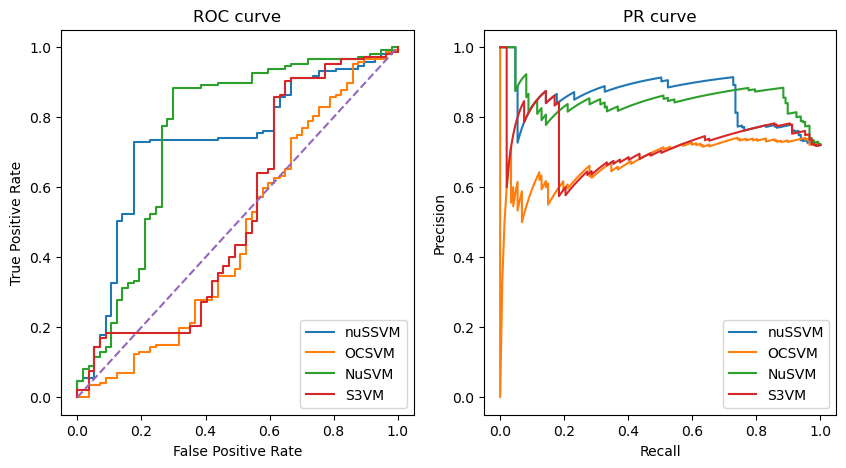

In [17]:
# Plot the ROC curve and the PR curve

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(results_nuSSVM_ecg['fpr_curve'], results_nuSSVM_ecg['tpr_curve'])
plt.plot(results_ocsvm_ecg['fpr_curve'], results_ocsvm_ecg['tpr_curve'])
plt.plot(results_nusvm_ecg['fpr_curve'], results_nusvm_ecg['tpr_curve'])
plt.plot(results_s3vm_ecg['fpr_curve'], results_s3vm_ecg['tpr_curve'])
plt.plot([0,1],[0,1],'--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(['nuSSVM', 'OCSVM', 'NuSVM', 'S3VM'])
plt.subplot(1,2,2)
plt.plot(results_nuSSVM_ecg['recall_curve'], results_nuSSVM_ecg['precision_curve'])
plt.plot(results_ocsvm_ecg['recall_curve'], results_ocsvm_ecg['precision_curve'])
plt.plot(results_nusvm_ecg['recall_curve'], results_nusvm_ecg['precision_curve'])
plt.plot(results_s3vm_ecg['recall_curve'], results_s3vm_ecg['precision_curve'])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('PR curve')
plt.legend(['nuSSVM', 'OCSVM', 'NuSVM', 'S3VM'])
plt.show()

